# Denoising Recordings Using Known Noise Recordings
This notebook demonstrates how to denoise audio recordings using two known noise recordings and a simple machine learning technique.

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
import librosa
import librosa.display
import os

In [ ]:
# Load audio data
noisy_files = ["../data/processed/recording 1.wav", "../data/processed/recording 2.wav"]
noise_files = ["../data/processed/event.wav", "../data/processed/event 2.wav"]
noisy_signals = [librosa.load(file, sr=44100)[0] for file in noisy_files]
noise_signals = [librosa.load(file, sr=44100)[0] for file in noise_files]

In [ ]:
# Preprocess data
def compute_spectrogram(signal):
    return librosa.stft(signal, n_fft=1024, hop_length=512).T
noisy_spectrograms = [compute_spectrogram(signal) for signal in noisy_signals]
noise_spectrograms = [compute_spectrogram(signal) for signal in noise_signals]

In [35]:
# Build a simple denoising model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(1024, 1024, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(1, (3, 3), activation='linear', padding='same')
])
model.compile(optimizer='adam', loss='mse')

In [36]:
# Train the model
def pad_spectrograms(spectrograms, target_shape):
	padded_spectrograms = []
	for spectrogram in spectrograms:
		pad_width = [(0, max(0, target_shape[0] - spectrogram.shape[0])), 
					 (0, max(0, target_shape[1] - spectrogram.shape[1]))]
		padded_spectrogram = np.pad(spectrogram, pad_width, mode='constant')
		padded_spectrograms.append(padded_spectrogram[:target_shape[0], :target_shape[1]])
	return np.array(padded_spectrograms)

# Define target shape for spectrograms
target_shape = (1024, 1024)

# Pad spectrograms to ensure uniform shape
X_train = pad_spectrograms(noisy_spectrograms, target_shape).reshape(-1, 1024, 1024, 1)
y_train = pad_spectrograms(noise_spectrograms, target_shape).reshape(-1, 1024, 1024, 1)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0339
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0339
Epoch 2/10
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step - loss: 0.0298
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step - loss: 0.0298
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step - loss: 0.0290
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step - loss: 0.0290
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step - loss: 0.0282
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step - loss: 0.0282
Epoch 5/10
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step - loss: 0.0271
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step - loss: 0.0271
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step - loss: 0.0262
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step - loss: 0.0262
Epoch 7/10
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step - loss: 0.0258
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step - loss: 0.0258
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step - loss: 0.0257
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━

In [38]:
# Apply the model to denoise
denoised_spectrograms = []
for spectrogram in noisy_spectrograms:
	# Ensure the spectrogram has the correct shape
	padded_spectrogram = np.pad(spectrogram, 
								[(0, max(0, target_shape[0] - spectrogram.shape[0])), 
								 (0, max(0, target_shape[1] - spectrogram.shape[1]))], 
								mode='constant')
	reshaped_spectrogram = padded_spectrogram[:target_shape[0], :target_shape[1]].reshape(1, target_shape[0], target_shape[1], 1)
	denoised_spectrogram = model.predict(reshaped_spectrogram)
	denoised_spectrograms.append(denoised_spectrogram[0, :, :, 0])  # Remove batch and channel dimensions

# Convert denoised spectrograms back to time-domain signals
denoised_signals = [librosa.istft(spectrogram.T) for spectrogram in denoised_spectrograms]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


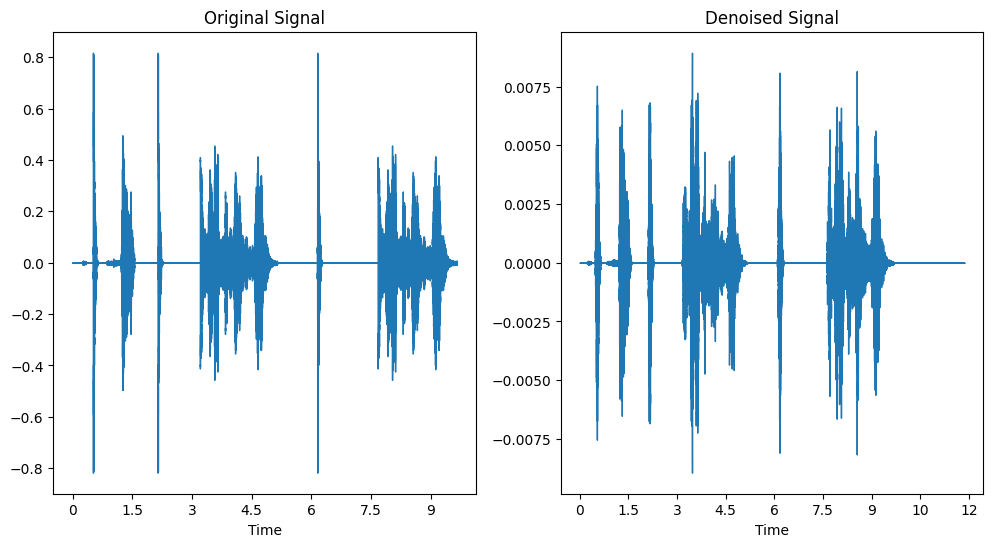

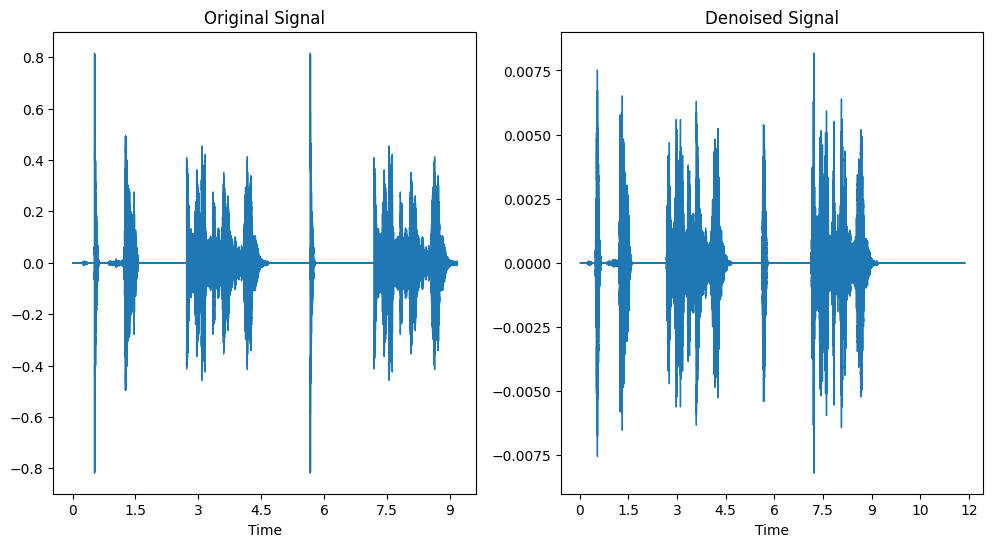

In [39]:
# Compare denoised results with original signals
import matplotlib.pyplot as plt
for i, (original, denoised) in enumerate(zip(noisy_signals, denoised_signals)):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(original, sr=44100)
    plt.title('Original Signal')
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(denoised, sr=44100)
    plt.title('Denoised Signal')
    plt.show()  
    

In [41]:
# Save denoised recordings
import soundfile as sf

output_dir = "../output/denoised/"
os.makedirs(output_dir, exist_ok=True)
for i, signal in enumerate(denoised_signals):
    sf.write(os.path.join(output_dir, f"denoised_{i+1}.wav"), signal, sr, format='WAV')